## Load data files

In [1]:
import codecs
from tensorflow.keras.utils import to_categorical
import numpy as np

def load_data(filename):
    with codecs.open(filename, 'r', 'utf-8') as f:
        x, y = zip(*[d.strip().split('\t') for d in f])
    x = np.asarray(list(x))
    y = to_categorical(y, 3)
    
    return x, y
    
x_token_train, y_token_train = load_data('data/token_train.tsv')
x_token_test, y_token_test = load_data('data/token_test.tsv')
x_morph_train, y_morph_train = load_data('data/morph_train.tsv')
x_morph_test, y_morph_test = load_data('data/morph_test.tsv')

print('X token train shape: {}'.format(x_token_train.shape))
print('X token test shape: {}'.format(x_token_test.shape))

print('X morph train shape: {}'.format(x_morph_train.shape))
print('X morph test shape: {}'.format(x_morph_test.shape))

X token train shape: (10244,)
X token test shape: (2560,)
X morph train shape: (10244,)
X morph test shape: (2560,)


## Prepare
Convert text (train & test) to sequences and pad to requested document length

In [2]:
from tensorflow.keras.preprocessing import text, sequence

def tokenizer(x_train, x_test, vocabulary_size, char_level):
    tokenize = text.Tokenizer(num_words=vocabulary_size, 
                              char_level=char_level,
                              filters='')
    tokenize.fit_on_texts(x_train)  # only fit on train
    x_train = tokenize.texts_to_sequences(x_train)
    x_test = tokenize.texts_to_sequences(x_test)
    
    return x_train, x_test

def pad(x_train, x_test, max_document_length):
    x_train = sequence.pad_sequences(x_train, maxlen=max_document_length, padding='post', truncating='post')
    x_test = sequence.pad_sequences(x_test, maxlen=max_document_length, padding='post', truncating='post')
    
    return x_train, x_test

vocabulary_size = 5000

x_token_train, x_token_test = tokenizer(x_token_train, x_token_test, vocabulary_size, True)
x_morph_train, x_morph_test = tokenizer(x_morph_train, x_morph_test, vocabulary_size, True)

max_document_length = 300

x_token_train, x_token_test = pad(x_token_train, x_token_test, max_document_length)
x_morph_train, x_morph_test = pad(x_morph_train, x_morph_test, max_document_length)

print('X token train shape: {}'.format(x_token_train.shape))
print('X token test shape: {}'.format(x_token_test.shape))

print('X morph train shape: {}'.format(x_morph_train.shape))
print('X morph test shape: {}'.format(x_morph_test.shape))

X token train shape: (10244, 300)
X token test shape: (2560, 300)
X morph train shape: (10244, 300)
X morph test shape: (2560, 300)


In [3]:
print('Token OOV ratio: {} ({} out of 228)'.format(np.count_nonzero(x_token_test == 228)/228, np.count_nonzero(x_token_test == 228)))
print('Morph OOV ratio: {} ({} out of 228)'.format(np.count_nonzero(x_morph_test == 228)/228, np.count_nonzero(x_morph_test == 228)))

Token OOV ratio: 0.0 (0 out of 228)
Morph OOV ratio: 0.0 (0 out of 228)


## Plot function

In [4]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(history, model_name, dataset_kind):
    
    fig, axs = plt.subplots(1, 2, sharex=True)
    
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title('Model Loss')
    axs[0].legend(['Train', 'Validation'], loc='upper left')
    
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title('Model Accuracy')
    axs[1].legend(['Train', 'Validation'], loc='upper left')
    
    fig.suptitle('{}-{}'.format(model_name, dataset_kind), fontsize=16)
    fig.tight_layout()
    plt.show()

## Import required modules from Keras

In [5]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers, metrics, layers

## Default Parameters

In [6]:
import os
try:
    os.mkdir('word_saved_models')
except FileExistsError:
    pass

dropout_keep_prob=0.5
embedding_size=300

token_dataset = ("Token", (x_token_train, y_token_train), (x_token_test, y_token_test))
morph_dataset = ("Morph", (x_morph_train, y_morph_train), (x_morph_test, y_morph_test))

def run_experiment(model, dataset, num_epochs,
                   optimizer=optimizers.Adam(lr=1e-4),
                   batch_size=50,
                   dev_size=0.2):
    [dataset_kind, (x_train, y_train), (x_test, y_test)] = dataset
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    # Train the model
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=num_epochs,
                        verbose=1,
                        validation_split=dev_size)

    # Plot training accuracy and loss
    plot_loss_and_accuracy(history, model.name, dataset_kind)

    # Evaluate the model
    [_, accuracy, *_] = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
    print()
    print('Accuracy: {:.4f}'.format(accuracy))

    # Save the model
    model.save('word_saved_models/{}-{}-{:.3f}.h5'.format(model.name, dataset_kind, accuracy * 100))

## Linear

In [7]:
def construct_linear():
    return Sequential([
        layers.Input(shape=(max_document_length,)),
        layers.Dense(100),
        layers.Dropout(dropout_keep_prob),
        layers.Dense(3, activation='softmax')
    ], name="Linear")

### Linear - Token

Epoch 1/10
164/164 [==============================] - 0s 3ms/step - loss: 7.2598 - accuracy: 0.5463 - val_loss: 4.3958 - val_accuracy: 0.6628
Epoch 2/10
164/164 [==============================] - 0s 2ms/step - loss: 6.0476 - accuracy: 0.5980 - val_loss: 3.9234 - val_accuracy: 0.6759
Epoch 3/10
164/164 [==============================] - 0s 2ms/step - loss: 5.4845 - accuracy: 0.6050 - val_loss: 3.4190 - val_accuracy: 0.6769
Epoch 4/10
164/164 [==============================] - 0s 2ms/step - loss: 4.9600 - accuracy: 0.6060 - val_loss: 3.0746 - val_accuracy: 0.6696
Epoch 5/10
164/164 [==============================] - 0s 2ms/step - loss: 4.4767 - accuracy: 0.6040 - val_loss: 2.8641 - val_accuracy: 0.6818
Epoch 6/10
164/164 [==============================] - 0s 2ms/step - loss: 4.3279 - accuracy: 0.6044 - val_loss: 2.6827 - val_accuracy: 0.6857
Epoch 7/10
164/164 [==============================] - 0s 2ms/step - loss: 3.9206 - accuracy: 0.6055 - val_loss: 2.3026 - val_accuracy: 0.6789
Epoch 

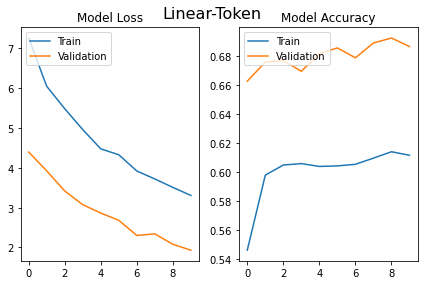

52/52 [==============================] - 0s 2ms/step - loss: 1.8047 - accuracy: 0.6871

Accuracy: 0.6871


In [8]:
run_experiment(construct_linear(), token_dataset, num_epochs=10)

### Linear - Morph

Epoch 1/10
164/164 [==============================] - 0s 3ms/step - loss: 6.3427 - accuracy: 0.5650 - val_loss: 3.5468 - val_accuracy: 0.6828
Epoch 2/10
164/164 [==============================] - 0s 2ms/step - loss: 4.6179 - accuracy: 0.5989 - val_loss: 2.9943 - val_accuracy: 0.6935
Epoch 3/10
164/164 [==============================] - 0s 2ms/step - loss: 4.1173 - accuracy: 0.5989 - val_loss: 2.4201 - val_accuracy: 0.6901
Epoch 4/10
164/164 [==============================] - 0s 2ms/step - loss: 3.6135 - accuracy: 0.6082 - val_loss: 2.3026 - val_accuracy: 0.6896
Epoch 5/10
164/164 [==============================] - 0s 2ms/step - loss: 3.3664 - accuracy: 0.6052 - val_loss: 2.1194 - val_accuracy: 0.6920
Epoch 6/10
164/164 [==============================] - 0s 2ms/step - loss: 3.0516 - accuracy: 0.6066 - val_loss: 1.9442 - val_accuracy: 0.6969
Epoch 7/10
164/164 [==============================] - 0s 2ms/step - loss: 2.8247 - accuracy: 0.6132 - val_loss: 1.8321 - val_accuracy: 0.6935
Epoch 

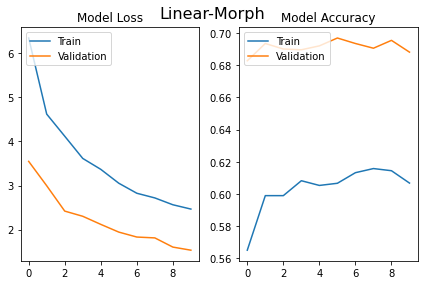

52/52 [==============================] - 0s 2ms/step - loss: 1.4126 - accuracy: 0.7000

Accuracy: 0.7000


In [9]:
run_experiment(construct_linear(), morph_dataset, num_epochs=10)

### CNN

In [10]:
def construct_cnn():
    text_input = layers.Input(shape=(max_document_length,))
    x = layers.Embedding(vocabulary_size, embedding_size)(text_input)
    convs = [layers.MaxPool1D()(layers.Conv1D(128, fsz, padding='valid', activation='relu')(x))
             for fsz in [10, 30]]
    x = layers.Concatenate(axis=1)(convs)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_keep_prob)(x)
    preds = layers.Dense(3, activation='softmax')(x)

    return Model(text_input, preds, name="CNN")

### CNN - Token

Epoch 1/5
164/164 [==============================] - 7s 42ms/step - loss: 0.6623 - accuracy: 0.7158 - val_loss: 0.5846 - val_accuracy: 0.7428
Epoch 2/5
164/164 [==============================] - 7s 40ms/step - loss: 0.5221 - accuracy: 0.7836 - val_loss: 0.5109 - val_accuracy: 0.7853
Epoch 3/5
164/164 [==============================] - 7s 40ms/step - loss: 0.4116 - accuracy: 0.8408 - val_loss: 0.4494 - val_accuracy: 0.8224
Epoch 4/5
164/164 [==============================] - 7s 40ms/step - loss: 0.2950 - accuracy: 0.8986 - val_loss: 0.4103 - val_accuracy: 0.8326
Epoch 5/5
164/164 [==============================] - 7s 41ms/step - loss: 0.2185 - accuracy: 0.9304 - val_loss: 0.3993 - val_accuracy: 0.8414


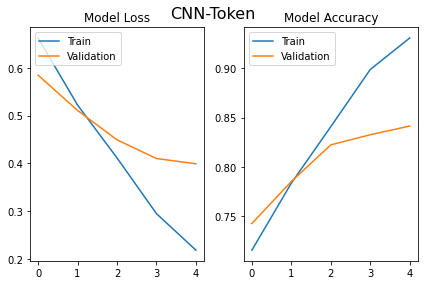

52/52 [==============================] - 1s 11ms/step - loss: 0.3943 - accuracy: 0.8570

Accuracy: 0.8570


In [11]:
run_experiment(construct_cnn(), token_dataset, num_epochs=5)

### CNN - Morph

Epoch 1/5
164/164 [==============================] - 7s 41ms/step - loss: 0.6701 - accuracy: 0.7086 - val_loss: 0.6002 - val_accuracy: 0.7321
Epoch 2/5
164/164 [==============================] - 7s 40ms/step - loss: 0.5379 - accuracy: 0.7684 - val_loss: 0.5134 - val_accuracy: 0.7809
Epoch 3/5
164/164 [==============================] - 7s 40ms/step - loss: 0.4375 - accuracy: 0.8246 - val_loss: 0.4641 - val_accuracy: 0.8033
Epoch 4/5
164/164 [==============================] - 7s 40ms/step - loss: 0.3377 - accuracy: 0.8754 - val_loss: 0.4193 - val_accuracy: 0.8287
Epoch 5/5
164/164 [==============================] - 7s 40ms/step - loss: 0.2464 - accuracy: 0.9218 - val_loss: 0.4021 - val_accuracy: 0.8438


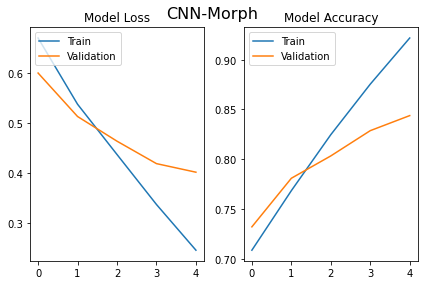

52/52 [==============================] - 1s 11ms/step - loss: 0.4216 - accuracy: 0.8426

Accuracy: 0.8426


In [12]:
run_experiment(construct_cnn(), morph_dataset, num_epochs=5)

## LSTM

In [13]:
def construct_lstm(units=93):
    return Sequential([
        layers.Embedding(vocabulary_size, embedding_size, input_length=max_document_length),
        layers.LSTM(units, return_sequences=True),
        layers.LSTM(units),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_keep_prob),
        layers.Dense(3, activation='softmax'),
    ], name="LSTM")

### LSTM - Token

Epoch 1/7
164/164 [==============================] - 8s 49ms/step - loss: 0.7405 - accuracy: 0.6892 - val_loss: 0.7098 - val_accuracy: 0.6994
Epoch 2/7
164/164 [==============================] - 7s 44ms/step - loss: 0.7115 - accuracy: 0.7005 - val_loss: 0.7107 - val_accuracy: 0.6994
Epoch 3/7
164/164 [==============================] - 7s 44ms/step - loss: 0.7107 - accuracy: 0.7009 - val_loss: 0.7096 - val_accuracy: 0.6994
Epoch 4/7
164/164 [==============================] - 7s 44ms/step - loss: 0.7111 - accuracy: 0.7009 - val_loss: 0.7108 - val_accuracy: 0.6999
Epoch 5/7
164/164 [==============================] - 7s 44ms/step - loss: 0.7081 - accuracy: 0.7016 - val_loss: 0.7097 - val_accuracy: 0.7013
Epoch 6/7
164/164 [==============================] - 7s 44ms/step - loss: 0.7095 - accuracy: 0.7020 - val_loss: 0.7083 - val_accuracy: 0.7013
Epoch 7/7
164/164 [==============================] - 7s 44ms/step - loss: 0.7075 - accuracy: 0.7015 - val_loss: 0.7107 - val_accuracy: 0.7008


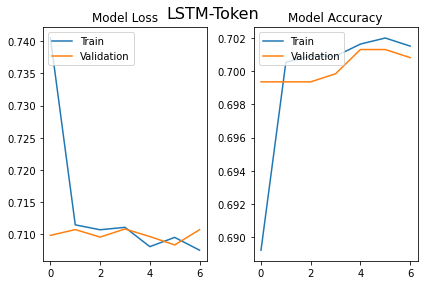

52/52 [==============================] - 1s 14ms/step - loss: 0.7073 - accuracy: 0.6938

Accuracy: 0.6938


In [14]:
run_experiment(construct_lstm(), token_dataset, num_epochs=7)

### LSTM - Morph

Epoch 1/7
164/164 [==============================] - 8s 49ms/step - loss: 0.7370 - accuracy: 0.6890 - val_loss: 0.7116 - val_accuracy: 0.7033
Epoch 2/7
164/164 [==============================] - 7s 44ms/step - loss: 0.7149 - accuracy: 0.6969 - val_loss: 0.7115 - val_accuracy: 0.6994
Epoch 3/7
164/164 [==============================] - 7s 44ms/step - loss: 0.7080 - accuracy: 0.7037 - val_loss: 0.7092 - val_accuracy: 0.6999
Epoch 4/7
164/164 [==============================] - 7s 44ms/step - loss: 0.7052 - accuracy: 0.7054 - val_loss: 0.7066 - val_accuracy: 0.7028
Epoch 5/7
164/164 [==============================] - 7s 44ms/step - loss: 0.7020 - accuracy: 0.7045 - val_loss: 0.7072 - val_accuracy: 0.7033
Epoch 6/7
164/164 [==============================] - 7s 44ms/step - loss: 0.6980 - accuracy: 0.7092 - val_loss: 0.6949 - val_accuracy: 0.7111
Epoch 7/7
164/164 [==============================] - 7s 44ms/step - loss: 0.6888 - accuracy: 0.7043 - val_loss: 0.7016 - val_accuracy: 0.7042


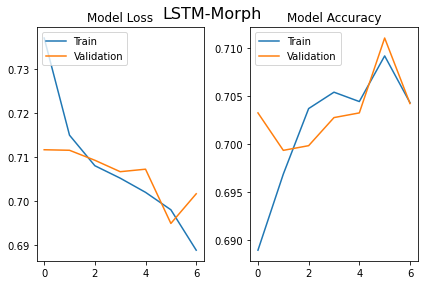

52/52 [==============================] - 1s 14ms/step - loss: 0.6994 - accuracy: 0.6973

Accuracy: 0.6973


In [15]:
run_experiment(construct_lstm(), morph_dataset, num_epochs=7)

## BiLSTM

In [ ]:
def construct_bilstm(units=93):
    return Sequential([
        layers.Embedding(vocabulary_size, embedding_size, input_length=max_document_length),
        layers.Bidirectional(layers.LSTM(units, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(units)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_keep_prob),
        layers.Dense(3, activation='softmax'),
    ], name="BiLSTM")

### BiLSTM - Token

In [ ]:
run_experiment(construct_bilstm(), token_dataset, num_epochs=4)

### BiLSTM - Morph

In [ ]:
run_experiment(construct_bilstm(), morph_dataset, num_epochs=4)

## MLP

In [19]:
def construct_mlp():
    return Sequential([
        layers.Embedding(vocabulary_size, embedding_size, input_length=max_document_length),
        layers.Flatten(),
        layers.Dense(256, activation='relu'), layers.Dropout(dropout_keep_prob),
        layers.Dense(128, activation='relu'), layers.Dropout(dropout_keep_prob),
        layers.Dense(64,  activation='relu'), layers.Dropout(dropout_keep_prob),
        layers.Dense(3, activation='softmax')
    ], name="MLP")

### MLP - Token

Epoch 1/6
164/164 [==============================] - 4s 25ms/step - loss: 0.7809 - accuracy: 0.6552 - val_loss: 0.6864 - val_accuracy: 0.7121
Epoch 2/6
164/164 [==============================] - 4s 24ms/step - loss: 0.6869 - accuracy: 0.7038 - val_loss: 0.6357 - val_accuracy: 0.7262
Epoch 3/6
164/164 [==============================] - 4s 24ms/step - loss: 0.6259 - accuracy: 0.7336 - val_loss: 0.5860 - val_accuracy: 0.7443 2s - loss: 0.6581 -  - ETA: 1s - loss: 0.6522  - E
Epoch 4/6
164/164 [==============================] - 4s 23ms/step - loss: 0.5585 - accuracy: 0.7741 - val_loss: 0.5490 - val_accuracy: 0.7648
Epoch 5/6
164/164 [==============================] - 4s 23ms/step - loss: 0.4856 - accuracy: 0.8118 - val_loss: 0.5224 - val_accuracy: 0.7775
Epoch 6/6
164/164 [==============================] - 4s 24ms/step - loss: 0.4202 - accuracy: 0.8411 - val_loss: 0.5075 - val_accuracy: 0.78480.4208 -  - ETA: 2s - - ETA: 


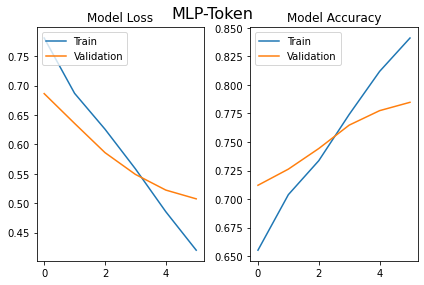

52/52 [==============================] - 0s 6ms/step - loss: 0.5143 - accuracy: 0.7895

Accuracy: 0.7895


In [20]:
run_experiment(construct_mlp(), token_dataset, num_epochs=6)

### MLP - Morph

Epoch 1/6
164/164 [==============================] - 4s 24ms/step - loss: 0.7910 - accuracy: 0.6539 - val_loss: 0.6620 - val_accuracy: 0.7150
Epoch 2/6
164/164 [==============================] - 4s 24ms/step - loss: 0.6863 - accuracy: 0.7051 - val_loss: 0.6371 - val_accuracy: 0.7257
Epoch 3/6
164/164 [==============================] - 4s 23ms/step - loss: 0.6355 - accuracy: 0.7287 - val_loss: 0.5909 - val_accuracy: 0.7472 
Epoch 4/6
164/164 [==============================] - 4s 23ms/step - loss: 0.5740 - accuracy: 0.7597 - val_loss: 0.5563 - val_accuracy: 0.7609
Epoch 5/6
164/164 [==============================] - 4s 24ms/step - loss: 0.5046 - accuracy: 0.7996 - val_loss: 0.5322 - val_accuracy: 0.7740 - accuracy: 0.
Epoch 6/6
164/164 [==============================] - 4s 23ms/step - loss: 0.4458 - accuracy: 0.8278 - val_loss: 0.5213 - val_accuracy: 0.7828


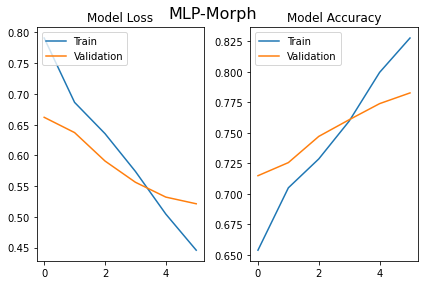

52/52 [==============================] - 0s 6ms/step - loss: 0.5201 - accuracy: 0.7781

Accuracy: 0.7781


In [21]:
run_experiment(construct_mlp(), morph_dataset, num_epochs=6)